### Setup and Configuration

In this section, we import necessary libraries and configure logging settings to streamline output management during execution.

In [1]:
# Import necessary libraries
from fitter import Fitter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from loguru import logger
import sys

In [2]:
# Remove all handlers associated with the logger for a clean slate
logger.remove()

In [3]:
# Adjust DataFrame display width for better readability
pd.set_option('display.width', 1000)  # If tables appear broken, consider zooming out or adjusting this value.

### Data Loading

In this section, we load the Wine dataset from the UCI Machine Learning Repository and assign column names for clarity and future reference.

In [4]:
# Load dataset and assign column names for readability
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
columns = [
    'Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 
    'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
    'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline'
]
df = pd.read_csv(url, names=columns)

### Summary Statistics

In this section, we output the summary statistics for each column in the dataset, providing insights into the central tendency and variability of the data.

In [5]:
# Print summary statistics for each feature in the dataset to understand data distribution
print("Summary Statistics for Each Column:")
print(df.describe())

Summary Statistics for Each Column:
            Class     Alcohol  Malic acid         Ash  Alcalinity of ash   Magnesium  Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  Color intensity         Hue  OD280/OD315 of diluted wines      Proline
count  178.000000  178.000000  178.000000  178.000000         178.000000  178.000000     178.000000  178.000000            178.000000       178.000000       178.000000  178.000000                    178.000000   178.000000
mean     1.938202   13.000618    2.336348    2.366517          19.494944   99.741573       2.295112    2.029270              0.361854         1.590899         5.058090    0.957449                      2.611685   746.893258
std      0.775035    0.811827    1.117146    0.274344           3.339564   14.282484       0.625851    0.998859              0.124453         0.572359         2.318286    0.228572                      0.709990   314.907474
min      1.000000   11.030000    0.740000    1.360000          10.600000

### Distribution Analysis and Visualization

In this section, we fit various probability distributions to each numerical feature in the dataset, overlay histograms with the probability density functions of the fitted distributions, and visually display the best fitting parameters on the plots for detailed analysis.

In [6]:
# Define the distributions to test against the data
distributions = ['gamma', 'rayleigh', 'norm', 'expon', 'lognorm']
distribution_names = {
    'gamma': 'Gamma Distribution',
    'rayleigh': 'Rayleigh Distribution',
    'norm': 'Normal Distribution',
    'expon': 'Exponential Distribution',
    'lognorm': 'Log-Normal Distribution',
}

In [7]:
# Define the detailed descriptions of parameters for each distribution
distribution_descriptions = {
    'gamma': {'a': "Shape", 'loc': "Location", 'scale': "Scale"},
    'rayleigh': {'loc': "Location", 'scale': "Scale"},
    'norm': {'loc': "Mean", 'scale': "Standard Deviation"},
    'expon': {'loc': "Location", 'scale': "Scale"},
    'lognorm': {'s': "Shape", 'loc': "Location", 'scale': "Scale"},
}

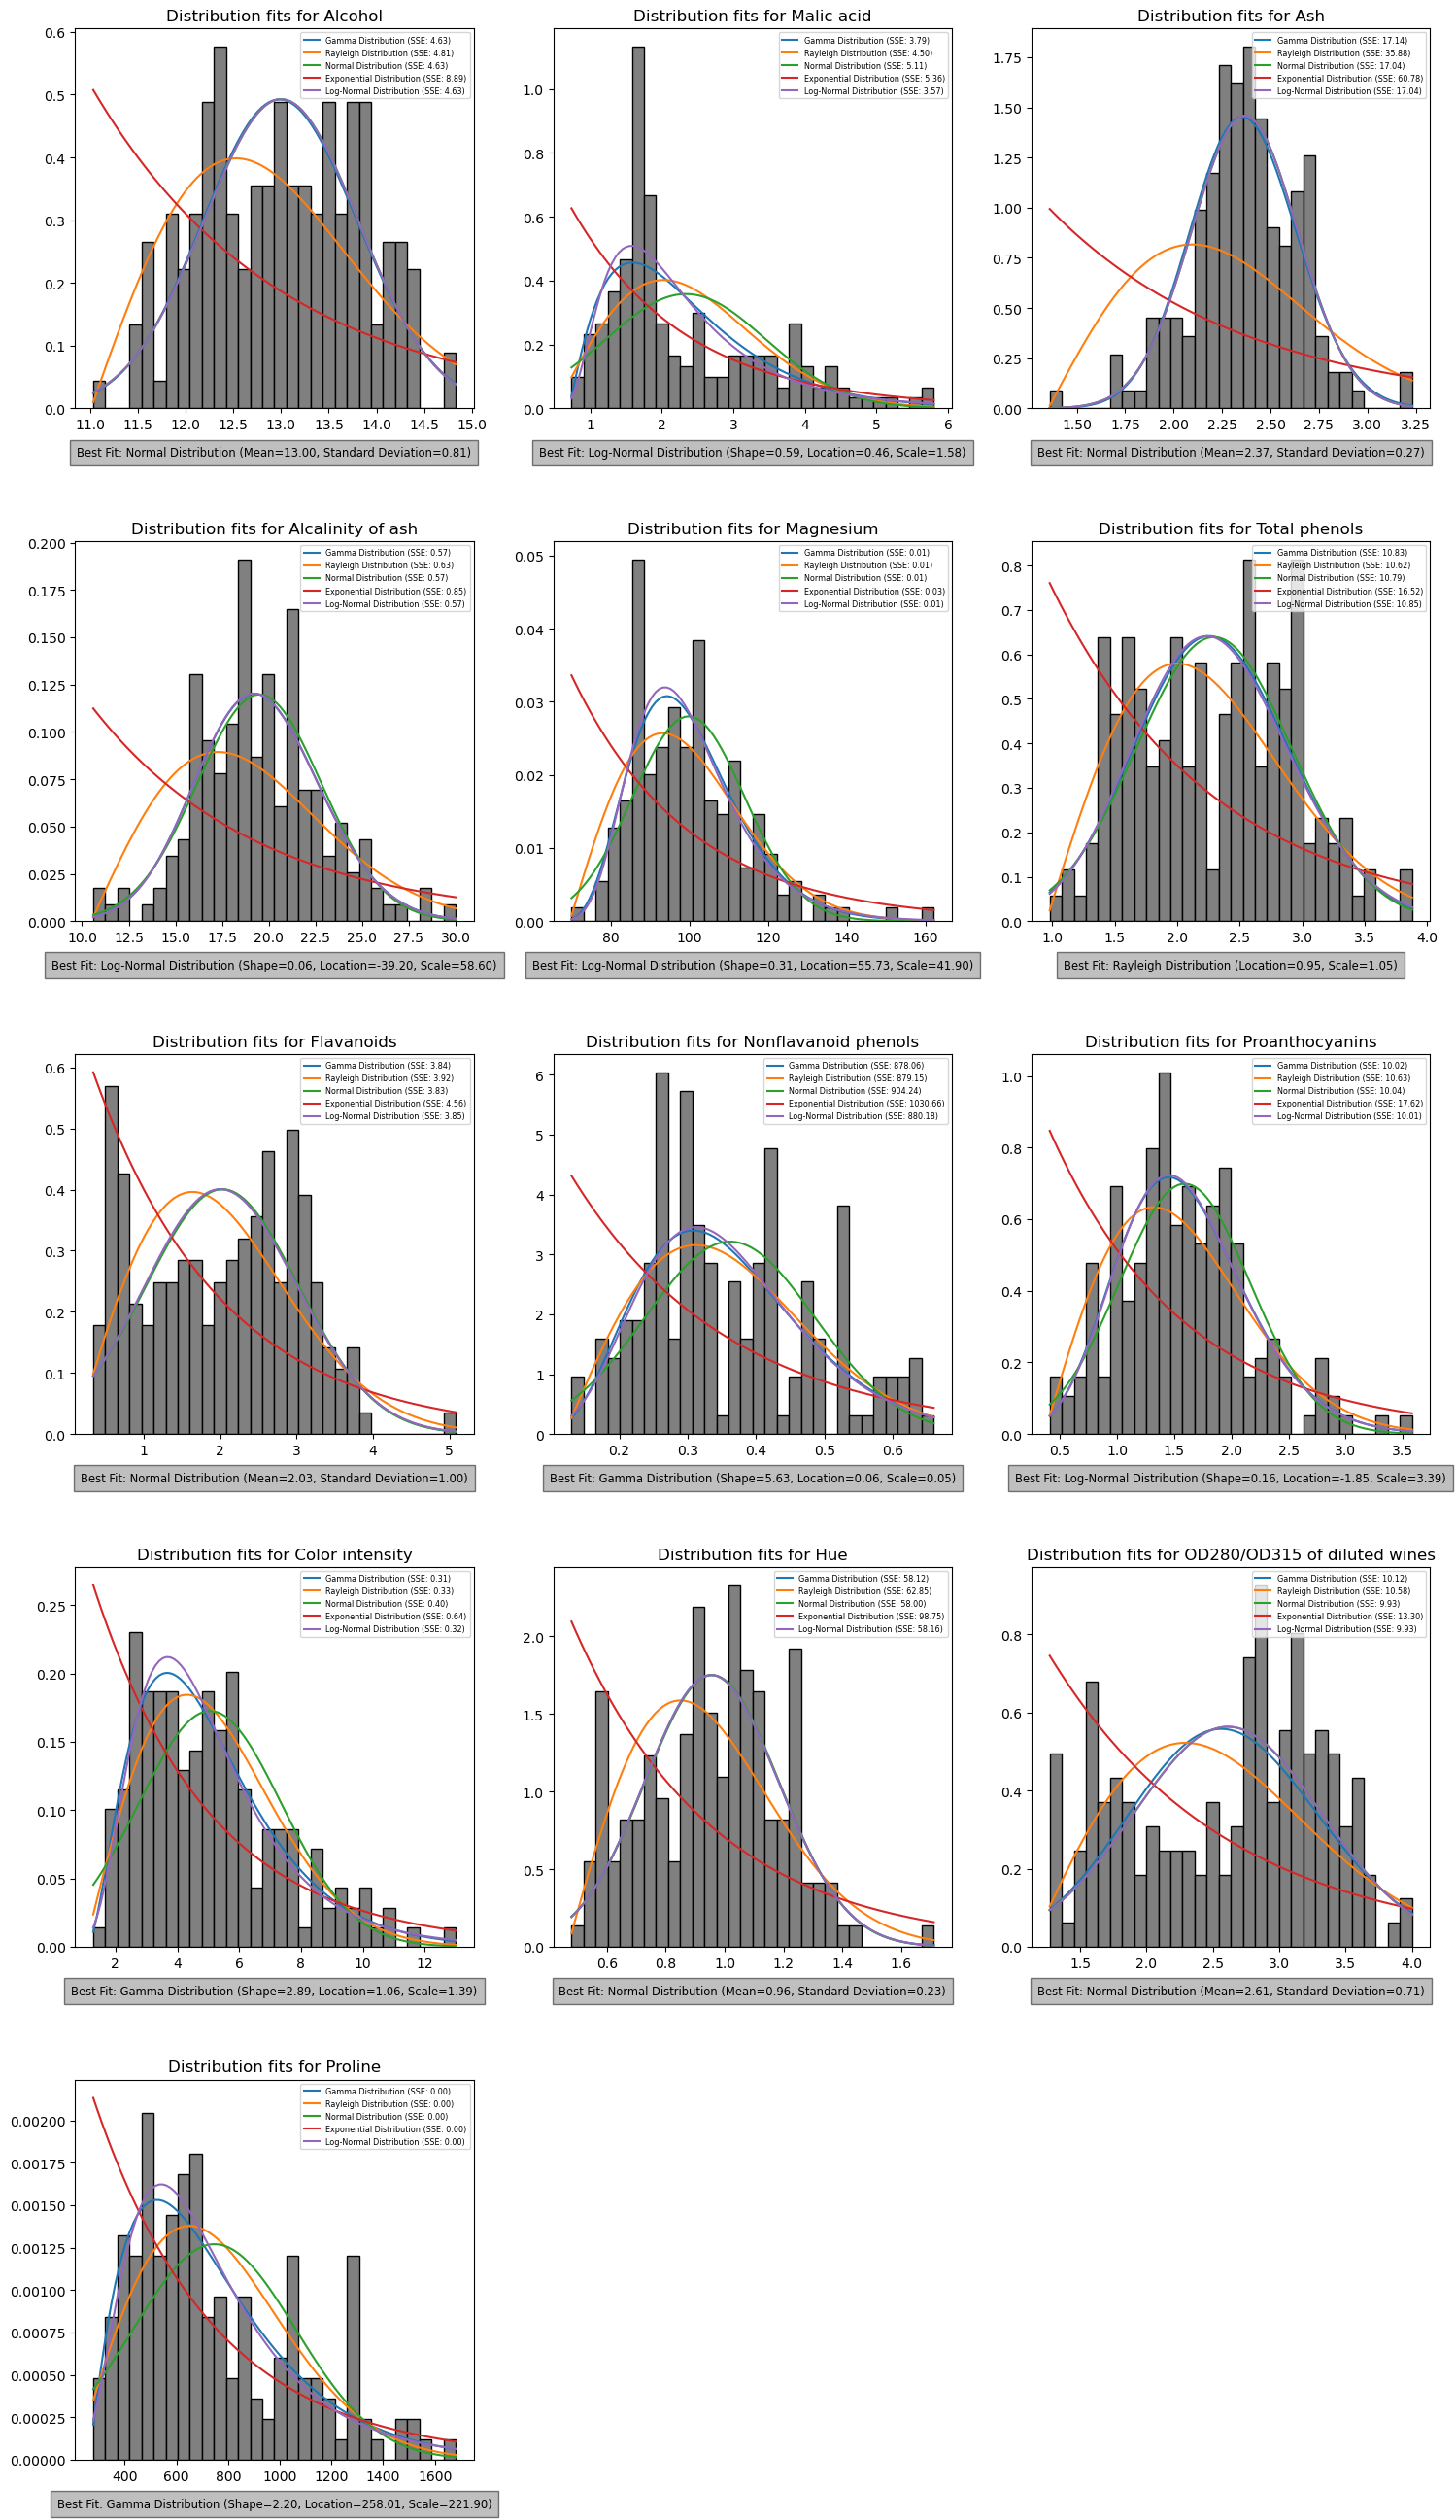

In [8]:
# Initialize subplot configuration based on number of features
num_features = len(df.columns) - 1
cols = 3
rows = (num_features + cols - 1) // cols
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, rows * 6.5))
axes = axes.flatten()

# Analyze and plot distributions for each feature
for index, column in enumerate(df.columns[1:]):
    ax = axes[index]
    data = df[column]
    f = Fitter(data, distributions=distributions)
    f.fit()
    ax.hist(data, bins=30, color='grey', edgecolor='black', density=True)
    
    # Plot the probability density function for each fitted distribution
    for dist_name in distributions:
        if dist_name in f.fitted_param:
            params = f.fitted_param[dist_name]
            sse = f.summary(plot=False).loc[dist_name, 'sumsquare_error']
            dist = getattr(stats, dist_name)
            x = np.linspace(min(data), max(data), 100)
            ax.plot(x, dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1]), 
                    label=f'{distribution_names[dist_name]} (SSE: {sse:.2f})')

    # Add legend, title, and best fit information
    ax.legend(loc='upper right', fontsize='xx-small')
    ax.set_title(f"Distribution fits for {column}")
    best_dist_name, best_dist_params = next(iter(f.get_best(method='sumsquare_error').items()))
    param_text = ', '.join([f"{distribution_descriptions[best_dist_name].get(key, key)}={value:.2f}" 
                            for key, value in best_dist_params.items()])
    ax.text(0.5, -0.1, f"Best Fit: {distribution_names[best_dist_name]} ({param_text})", 
            fontsize='small', transform=ax.transAxes, ha='center', va='top', bbox={"facecolor":"grey", "alpha":0.5, "pad":5})

# Clean up any unused axes
for i in range(num_features, rows * cols):
    fig.delaxes(axes[i])

# Adjust subplot spacing
plt.subplots_adjust(hspace=0.35)
plt.show()

### Correlation Analysis

In this section, we compute and display a heatmap of the correlation matrix among the features in the Wine dataset, helping identify relationships between variables.

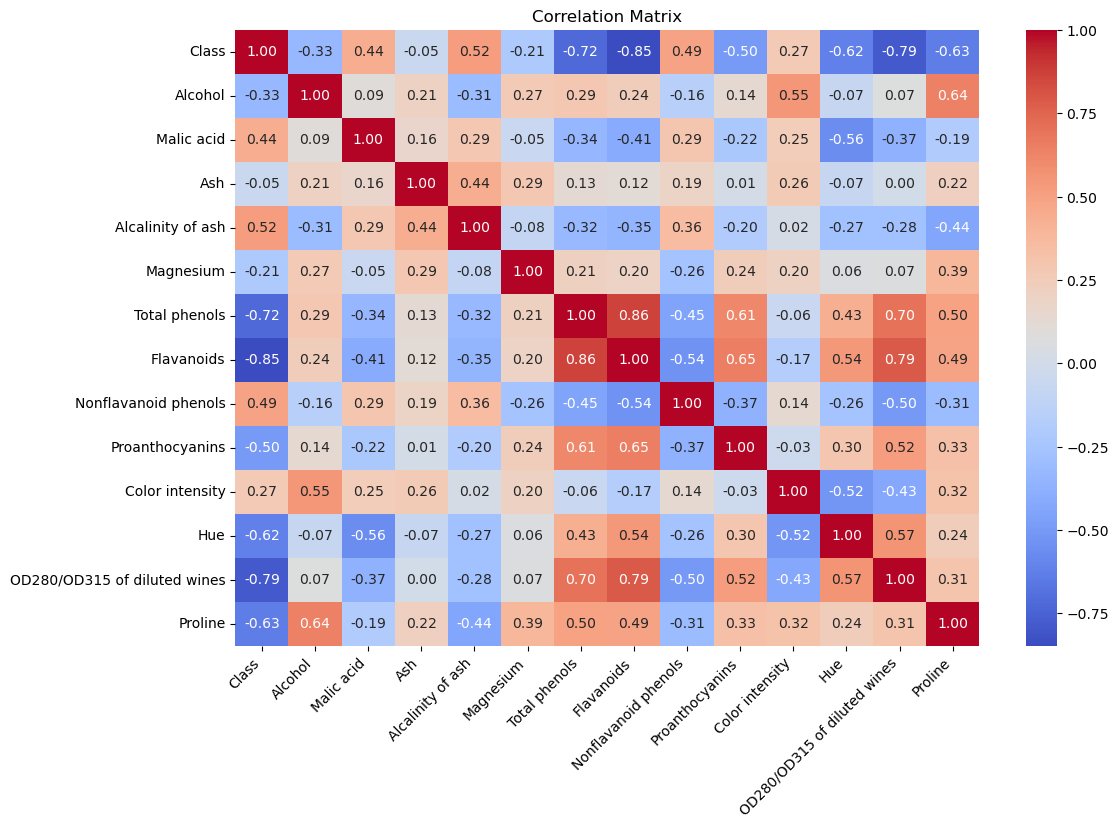

In [9]:
# Create a heatmap of the correlation matrix to visualize relationships between features
plt.figure(figsize=(12, 8))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

### Statistical Testing

In this section, we perform statistical tests between all pairs of classes from the Wine dataset to determine significant differences in their chemical properties. This includes a t-test for mean differences and Levene's test for variance equality, providing a comprehensive understanding of the variations across different classes.

In [10]:
# Define a function to perform two-sample t-test, supporting both pooled and separate variance
def two_sample_t_test(sample1, sample2, equal_var=True):
    n1, n2 = len(sample1), len(sample2)
    mean1, mean2 = np.mean(sample1), np.mean(sample2)
    std1, std2 = np.std(sample1, ddof=1), np.std(sample2, ddof=1)

    if equal_var:
        # Pooled standard deviation calculation
        s = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
        se = s * np.sqrt(1/n1 + 1/n2)
    else:
        # Separate variance estimate (Welch's t-test)
        se = np.sqrt(std1**2/n1 + std2**2/n2)

    # Compute the t-statistic
    t = (mean1 - mean2) / se
    
    # Calculate degrees of freedom based on variance method
    if equal_var:
        df = n1 + n2 - 2
    else:
        df = (std1**2/n1 + std2**2/n2)**2 / ((std1**2/n1)**2 / (n1-1) + (std2**2/n2)**2 / (n2-1))
    
    # Calculate the two-tailed p-value
    p = 2 * stats.t.cdf(-np.abs(t), df)
    return t, p, df

In [11]:
# Define a function for Levene's test to assess the equality of variances
def levene_test(sample1, sample2):
    W, p_value = stats.levene(sample1, sample2)
    return W, p_value

In [12]:
# Define a main function to conduct full analysis on selected classes from the dataset
def full_analysis(df, class1, class2):
    results = []
    
    if 'Class' not in df.columns:
        return "Error: 'Class' column not found in DataFrame."

    for column in df.columns[1:]:  # Exclude 'Class' column from the analysis
        sample1 = df[df['Class'] == class1][column]
        sample2 = df[df['Class'] == class2][column]

        # Perform Levene's test to decide which variance approach to use
        W, p_var_test = levene_test(sample1, sample2)
        
        # Conditional execution of two-sample t-test based on variance equality
        if p_var_test > 0.05:
            t_stat, p_value, df_t = two_sample_t_test(sample1, sample2)
            equal_var = True
        else:
            t_stat, p_value, df_t = two_sample_t_test(sample1, sample2, equal_var=False)
            equal_var = False

        results.append({
            'Variable': column,
            'T-Statistic': t_stat,
            'P-Value': p_value,
            'Degrees of Freedom': df_t,
            'Equal Variances': equal_var,
            'Levene Test P-Value': p_var_test
        })

    return pd.DataFrame(results)

In [13]:
# Define the class pairs to compare
class_pairs = [(1, 2), (1, 3), (2, 3)]

In [14]:
# Loop through each pair of classes and run the analysis
for class1, class2 in class_pairs:
    result_df = full_analysis(df, class1, class2)
    print(f"Analysis Results Between Class {class1} and Class {class2}:")
    print(f"{result_df}\n")

Analysis Results Between Class 1 and Class 2:
                        Variable  T-Statistic       P-Value  Degrees of Freedom  Equal Variances  Levene Test P-Value
0                        Alcohol    16.478551  1.955170e-33          128.000000             True             0.577130
1                     Malic acid     0.519297  6.044844e-01          123.320428            False             0.015661
2                            Ash     4.289940  3.492814e-05          128.000000             True             0.071607
3              Alcalinity of ash    -6.031489  1.626380e-08          128.000000             True             0.058699
4                      Magnesium     4.692061  6.843593e-06          128.000000             True             0.350808
5                  Total phenols     7.420649  1.889329e-11          119.136890            False             0.000689
6                     Flavanoids     9.157282  2.602682e-15          113.659044            False             0.004549
7         